In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow import keras

import numpy as np
import collections
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import pickle
import glob
import re
import os

from tqdm import tqdm
from scipy.optimize import curve_fit

In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-06-09 12:17:01.863859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 12:17:01.903168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 12:17:01.903357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Upload test dataset

In [5]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

## File lists

In [3]:

energies = ['0', '0.1', '0.3', '0.6'] + [str(i) for i in range(1, 11)]

In [7]:
energies

['0', '0.1', '0.3', '0.6', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [6]:
proj_test_path = "../../juno_data/data/projections_opt/test"
target_test_path = "../../juno_data/data/real/test/targets"

test_proj_dict   = { e:None for e in energies}
test_target_dict = { e:None for e in energies}
for i, e in enumerate(energies):
    proj_files_path   = proj_test_path + "/e+_" + e
    target_files_path = target_test_path + "/e+_" + e
    
    proj_files   = os.listdir(proj_files_path)
    target_files = os.listdir(target_files_path)
    
    test_proj_dict[e]    = [file for file in proj_files if "npy" in file] 
    test_target_dict[e]  = [file for file in target_files if "targets" in file]
    
    test_proj_dict[e].sort(key=natural_keys)
    test_target_dict[e].sort(key=natural_keys)
    
    #test_target_dict[e] = test_target_dict[e][:50]

In [5]:
test_proj_dict['0']

['proj_raw_data_test_0.npy',
 'proj_raw_data_test_1.npy',
 'proj_raw_data_test_2.npy',
 'proj_raw_data_test_3.npy',
 'proj_raw_data_test_4.npy',
 'proj_raw_data_test_5.npy',
 'proj_raw_data_test_6.npy',
 'proj_raw_data_test_7.npy',
 'proj_raw_data_test_8.npy',
 'proj_raw_data_test_9.npy',
 'proj_raw_data_test_10.npy',
 'proj_raw_data_test_11.npy',
 'proj_raw_data_test_12.npy',
 'proj_raw_data_test_13.npy',
 'proj_raw_data_test_14.npy',
 'proj_raw_data_test_15.npy',
 'proj_raw_data_test_16.npy',
 'proj_raw_data_test_17.npy',
 'proj_raw_data_test_18.npy',
 'proj_raw_data_test_19.npy',
 'proj_raw_data_test_20.npy',
 'proj_raw_data_test_21.npy',
 'proj_raw_data_test_22.npy',
 'proj_raw_data_test_23.npy',
 'proj_raw_data_test_24.npy',
 'proj_raw_data_test_25.npy',
 'proj_raw_data_test_26.npy',
 'proj_raw_data_test_27.npy',
 'proj_raw_data_test_28.npy',
 'proj_raw_data_test_29.npy',
 'proj_raw_data_test_30.npy',
 'proj_raw_data_test_31.npy',
 'proj_raw_data_test_32.npy',
 'proj_raw_data_test

In [30]:
#test_target[:None]

['targets_test_0.csv',
 'targets_test_1.csv',
 'targets_test_2.csv',
 'targets_test_3.csv',
 'targets_test_4.csv',
 'targets_test_5.csv',
 'targets_test_6.csv',
 'targets_test_7.csv',
 'targets_test_8.csv',
 'targets_test_9.csv',
 'targets_test_10.csv',
 'targets_test_11.csv',
 'targets_test_12.csv',
 'targets_test_13.csv',
 'targets_test_14.csv',
 'targets_test_15.csv',
 'targets_test_16.csv',
 'targets_test_17.csv',
 'targets_test_18.csv',
 'targets_test_19.csv',
 'targets_test_20.csv',
 'targets_test_21.csv',
 'targets_test_22.csv',
 'targets_test_23.csv',
 'targets_test_24.csv',
 'targets_test_25.csv',
 'targets_test_26.csv',
 'targets_test_27.csv',
 'targets_test_28.csv',
 'targets_test_29.csv',
 'targets_test_30.csv',
 'targets_test_31.csv',
 'targets_test_32.csv',
 'targets_test_33.csv',
 'targets_test_34.csv',
 'targets_test_35.csv',
 'targets_test_36.csv',
 'targets_test_37.csv',
 'targets_test_38.csv',
 'targets_test_39.csv',
 'targets_test_40.csv',
 'targets_test_41.csv',
 '

## Load test images

In [7]:
def get_data_from_filename(filename):
    # Read the corresponding label file

    npdata = np.load(filename, mmap_mode='r')

    return (npdata)

def get_data_wrapper(filename):
    # Assuming here that both your data and label is double type
    features = tf.numpy_function(
        get_data_from_filename, [filename], tf.float64) 
    return tf.data.Dataset.from_tensor_slices(features)
'''
# Create dataset of filenames.
ds = tf.data.Dataset.from_tensor_slices([data_path + file for file in tqdm(test_proj)])
# Retrieve .npy files
ds = ds.flat_map(get_data_wrapper)
# Optimizations
ds = ds.apply(tf.data.experimental.prefetch_to_device("/GPU:0"))
ds = ds.batch(64, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
'''

'\n# Create dataset of filenames.\nds = tf.data.Dataset.from_tensor_slices([data_path + file for file in tqdm(test_proj)])\n# Retrieve .npy files\nds = ds.flat_map(get_data_wrapper)\n# Optimizations\nds = ds.apply(tf.data.experimental.prefetch_to_device("/GPU:0"))\nds = ds.batch(64, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)\n'

In [8]:
[proj_test_path + "/e+_" + energies[0] + '/' + file for file in test_proj_dict[energies[0]]]

['../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_0.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_1.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_2.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_3.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_4.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_5.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_6.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_7.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_8.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_9.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_10.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_11.npy',
 '../../juno_data/data/projections_opt/test/e+_0/proj_raw_data_test_12.npy',
 '../../j

In [15]:
test_images = {e:None for e in energies}

for e in energies:

    ds = tf.data.Dataset.from_tensor_slices([proj_test_path + "/e+_" + e + '/' + file for file in test_proj_dict[e]])
    # Retrieve .npy files
    ds = ds.flat_map(get_data_wrapper)
    # Optimizations
    ds = ds.apply(tf.data.experimental.prefetch_to_device("/GPU:0"))
    ds = ds.batch(64, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    
    test_images[e] = ds

In [8]:
#test_images = np.empty(shape=(0, 230, 124, 2))

#test_images = np.concatenate([np.load(data_path + file) for file in tqdm(test_proj)])

#for file in tqdm(test_proj):
#    f   = np.load(data_path + file)["arr_0"]
#    test_images = np.concatenate((test_images, f), axis=0)


#test_images.shape

100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


(50000, 230, 124, 2)

## Load test targets

In [7]:
## labels
test_labels = {e:None for e in energies}
for e in energies:
    test_labels[e] = np.empty(shape = (0))
    for file in test_target_dict[e]:
        f = np.array(pd.read_csv(target_test_path + "/e+_" + e + '/' + file)["edep"])
        test_labels[e] = np.concatenate((test_labels[e], f), axis=0)

In [10]:
#test_labels = np.empty(shape=(0))

#test_labels = np.concatenate([pd.read_csv(target_path + file)["edep"].to_numpy() for file in tqdm(test_target)])

#for file in tqdm(test_target):
#    f   = pd.read_csv(target_path + file)["edep"].to_numpy()
#    test_labels = np.concatenate((test_labels, f), axis=0)
    
#test_labels.shape

100%|██████████| 100/100 [00:01<00:00, 74.40it/s]


(99999,)

# Adaptive LR object

In [11]:
#******CUSTOM LEARNING RATE******#
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate, epochs, steps_per_epoch):
    self.initial_learning_rate = initial_learning_rate
    self.epochs = epochs
    self.steps_per_epoch = steps_per_epoch
    self.m = initial_learning_rate / steps_per_epoch
    self.decay_rate = tf.constant((10**-8 / initial_learning_rate)**(((epochs - 1)*steps_per_epoch)**-1), dtype=tf.float32)
    print('decay_rate:', self.decay_rate)

  def __call__(self, step):
    result = tf.cond(tf.less(step, self.steps_per_epoch), 
                   lambda: self.m * (step+1),
                   lambda: self.initial_learning_rate * self.decay_rate**tf.cast(step+1-self.steps_per_epoch, dtype=tf.float32))

    #tf.print('lr at step', step, 'is', result, output_stream='file://learning_rates.txt')
    return result  

  def get_config(self):
      return {
          "initial_learning_rate": self.initial_learning_rate,
          "epochs": self.epochs,
          "steps_per_epoch": self.steps_per_epoch
      }

## Load ResNet model

In [12]:
resnet_model = tf.keras.models.load_model("./models/20220607-093041/", custom_objects={'MyLRSchedule': MyLRSchedule})

decay_rate: tf.Tensor(0.9999895, shape=(), dtype=float32)


# PREDICTION

In [17]:
# make predicitons
edep_pred = {e:None for e in energies}

for e in energies:
    edep_pred[e] = resnet_model.predict(test_images[e], verbose=1).reshape(-1)
    del test_images[e]

edep_pred['0'].shape

2022-06-09 12:26:45.920129: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 63s 40ms/step


2022-06-09 12:27:49.093861: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 63s 40ms/step


2022-06-09 12:28:52.517012: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 65s 41ms/step


2022-06-09 12:29:57.933817: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 68s 43ms/step


2022-06-09 12:31:05.855737: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 66s 42ms/step


2022-06-09 12:32:11.770092: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 63s 40ms/step


2022-06-09 12:33:14.485291: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 66s 42ms/step


2022-06-09 12:34:20.275708: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 63s 40ms/step


2022-06-09 12:35:23.054605: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 58s 37ms/step


2022-06-09 12:36:21.387311: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 61s 39ms/step


2022-06-09 12:37:22.388960: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 59s 37ms/step


2022-06-09 12:38:21.476857: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 62s 39ms/step


2022-06-09 12:39:23.165181: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 69s 44ms/step


2022-06-09 12:40:32.415333: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1563/1563 [==============================] - 66s 41ms/step


(99972,)

In [8]:
#### load predictions

edep_pred = np.load("edep_pred.npz", allow_pickle=True)

In [18]:
# 3sigma cut
res = {e:None for e in energies}

for e in energies:
    res[e] = (edep_pred[e]-test_labels[e])/test_labels[e]
    res[e] = res[e][np.abs(res[e] - res[e].mean()) < 3*res[e].std()]

In [19]:
def gaus(x, a, mu, sigma):
    return a*np.exp( -(x-mu)**2 / (2*sigma**2) )

'''hist, edges = np.histogram(res, bins=100)
bincenters = (edges[1:] + edges[:-1]) / 2

xgrid = np.linspace(edges[0], edges[-1], 500)

n     = res.shape[0]
mean  = res.mean()
sigma = res.std()
popt, pcov = curve_fit(gaus, bincenters, hist, p0=[n, mean, sigma])

n_events   = edep_pred.shape[0]
resolution = popt[2]
bias       = popt[1]

fig = plt.figure(figsize=(12,7), constrained_layout=True)
ax  = fig.add_subplot(111)

ax.hist(bincenters, weights=hist, bins=100)
ax.plot(xgrid, gaus(xgrid, *popt), lw=3)
ax.text(0.65, 0.75, f"number of events = {n_events}", fontsize=18,transform=ax.transAxes)
ax.text(0.65, 0.7, f"resolution = {resolution*100:.2f}%", fontsize=18,transform=ax.transAxes)
ax.text(0.65, 0.65, f"bias = {abs(bias)*100:.2f}%", fontsize=18,transform=ax.transAxes)

ax.set_title("E$_e$ = 1 MeV", fontsize=18)
ax.set_xlabel("(E$_{pred}$ - E$_{true}$) / E$_{true}$", fontsize=16)
ax.set_ylabel("counts", fontsize=16)


# ax.set_yscale("log")

ax.tick_params(axis="both", which="major", labelsize=14, length=5)

fig.savefig("./plots/e_1mev_hist_resnet1002.png", dpi=300, facecolor="white")

plt.show()'''

'hist, edges = np.histogram(res, bins=100)\nbincenters = (edges[1:] + edges[:-1]) / 2\n\nxgrid = np.linspace(edges[0], edges[-1], 500)\n\nn     = res.shape[0]\nmean  = res.mean()\nsigma = res.std()\npopt, pcov = curve_fit(gaus, bincenters, hist, p0=[n, mean, sigma])\n\nn_events   = edep_pred.shape[0]\nresolution = popt[2]\nbias       = popt[1]\n\nfig = plt.figure(figsize=(12,7), constrained_layout=True)\nax  = fig.add_subplot(111)\n\nax.hist(bincenters, weights=hist, bins=100)\nax.plot(xgrid, gaus(xgrid, *popt), lw=3)\nax.text(0.65, 0.75, f"number of events = {n_events}", fontsize=18,transform=ax.transAxes)\nax.text(0.65, 0.7, f"resolution = {resolution*100:.2f}%", fontsize=18,transform=ax.transAxes)\nax.text(0.65, 0.65, f"bias = {abs(bias)*100:.2f}%", fontsize=18,transform=ax.transAxes)\n\nax.set_title("E$_e$ = 1 MeV", fontsize=18)\nax.set_xlabel("(E$_{pred}$ - E$_{true}$) / E$_{true}$", fontsize=16)\nax.set_ylabel("counts", fontsize=16)\n\n\n# ax.set_yscale("log")\n\nax.tick_params(a

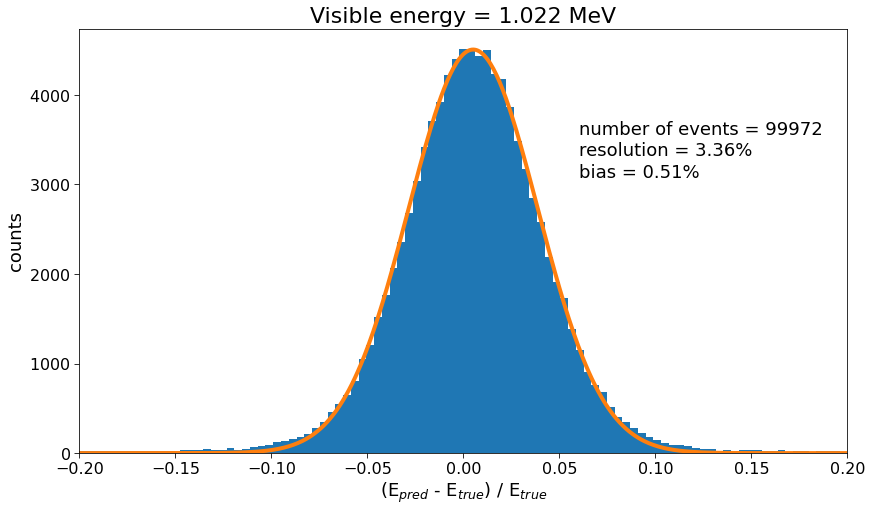

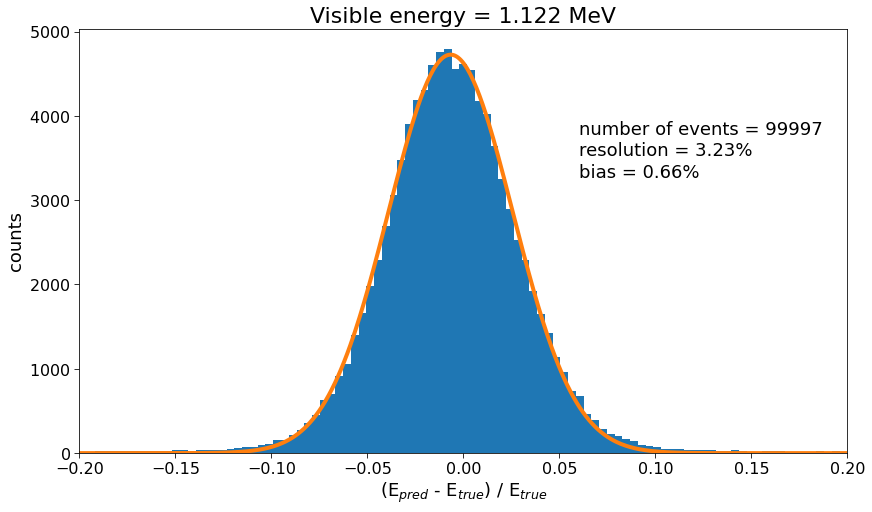

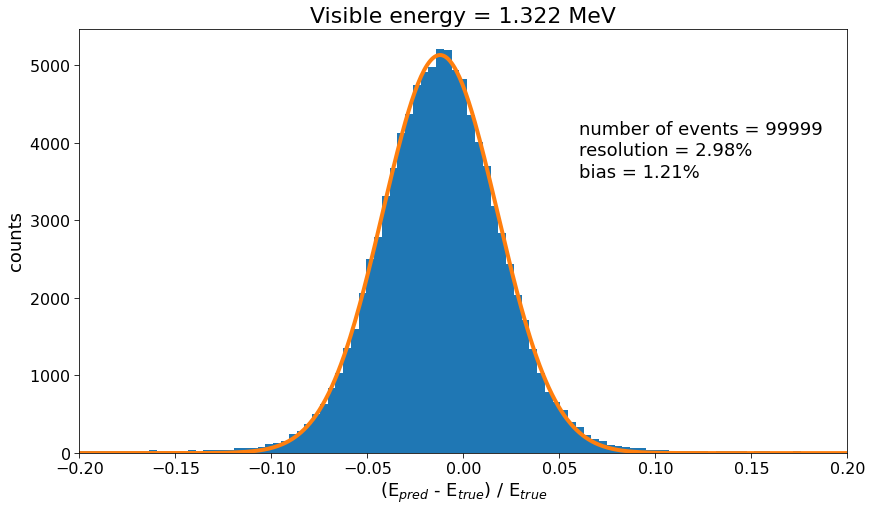

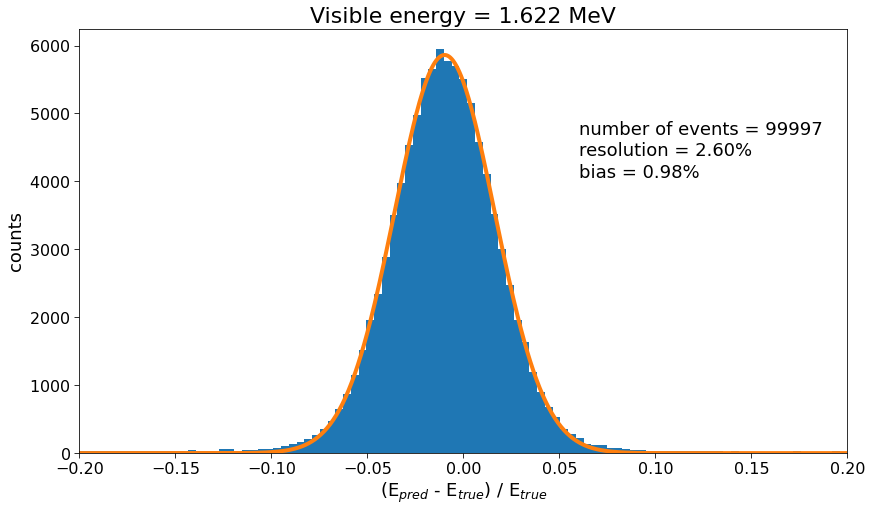

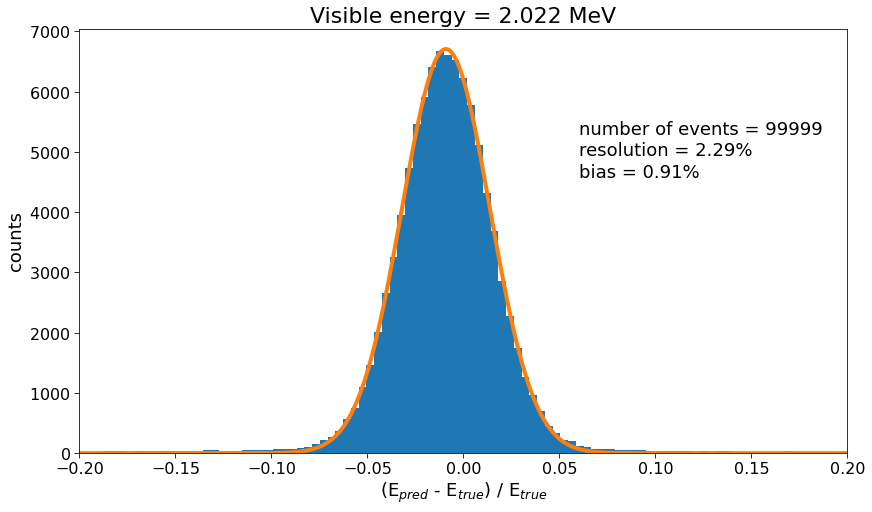

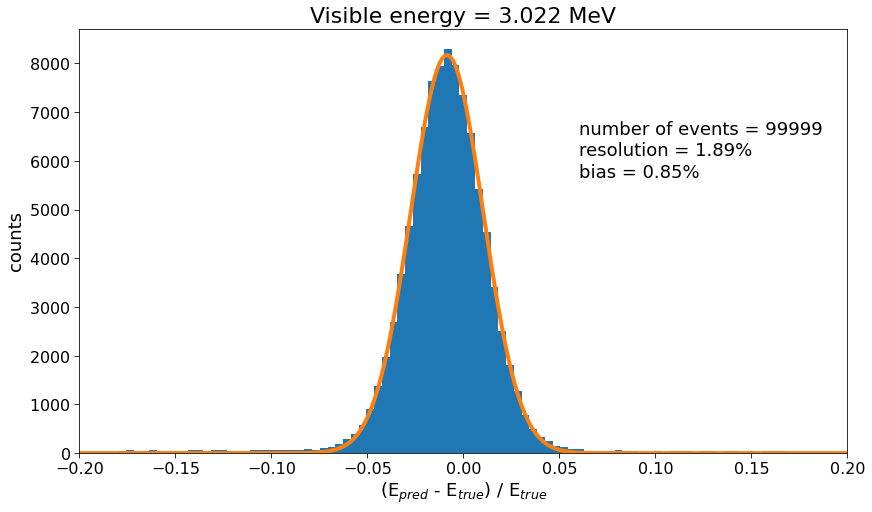

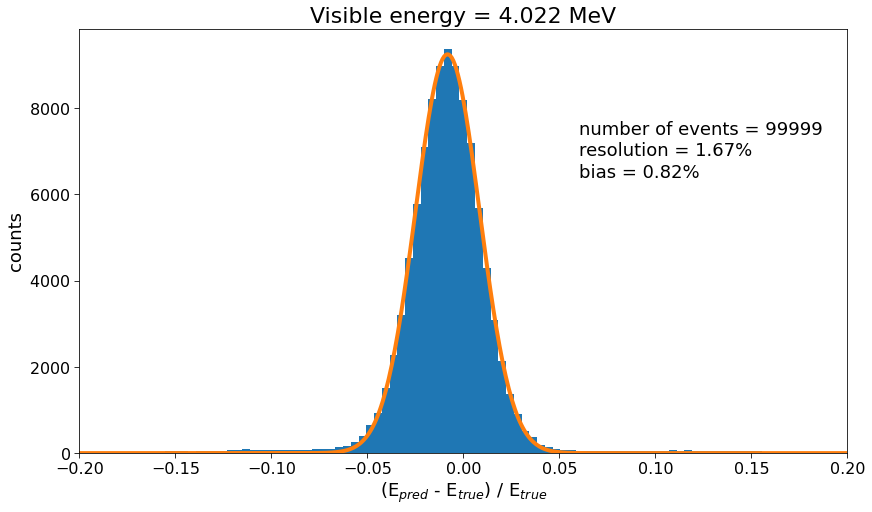

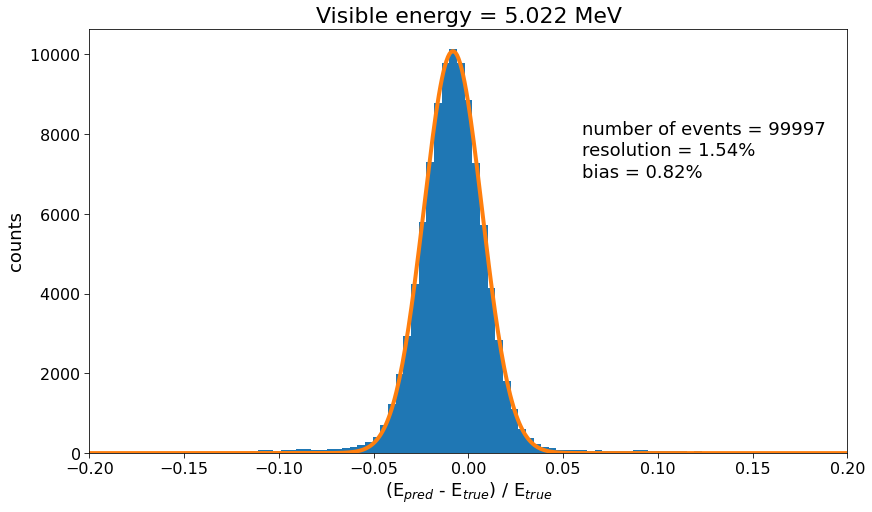

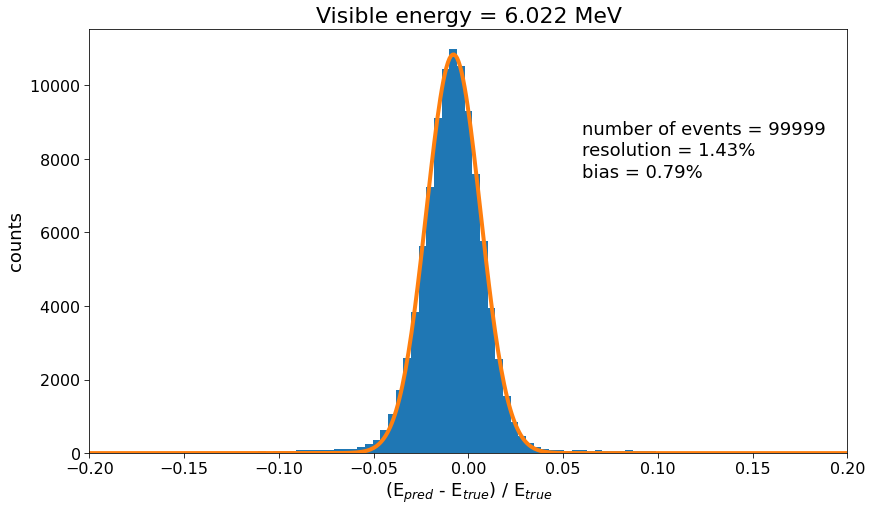

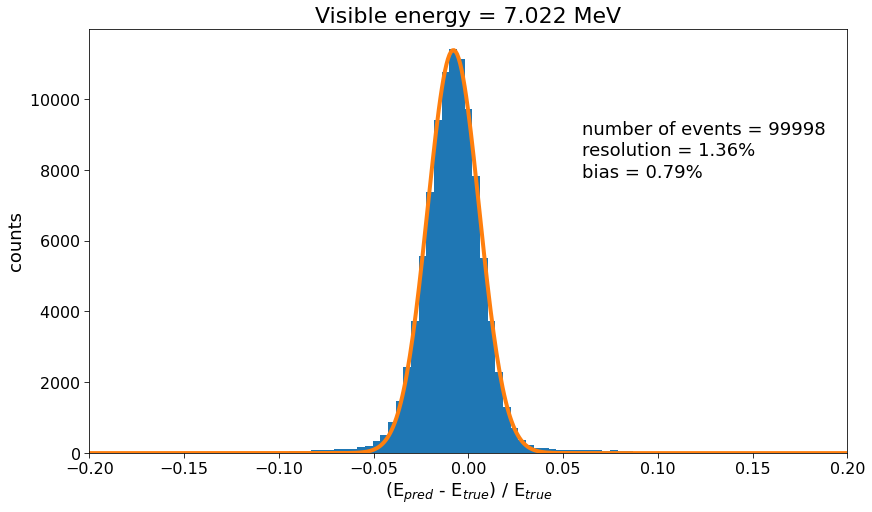

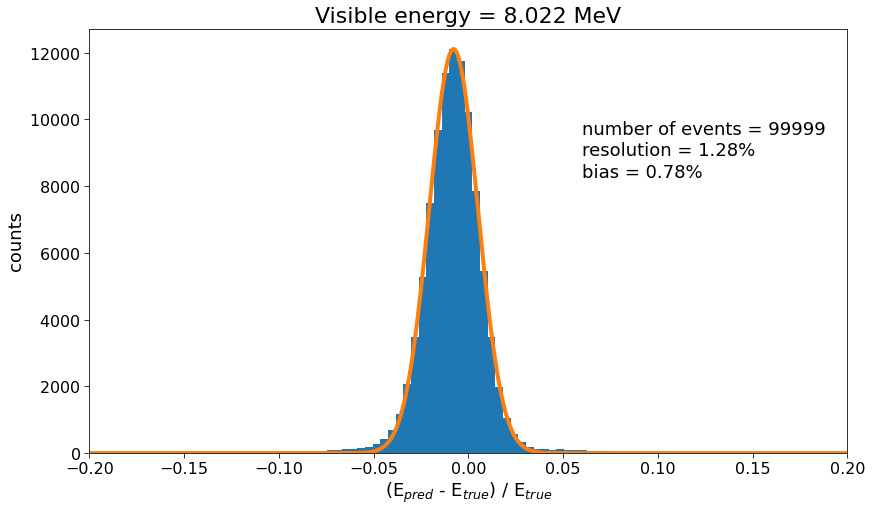

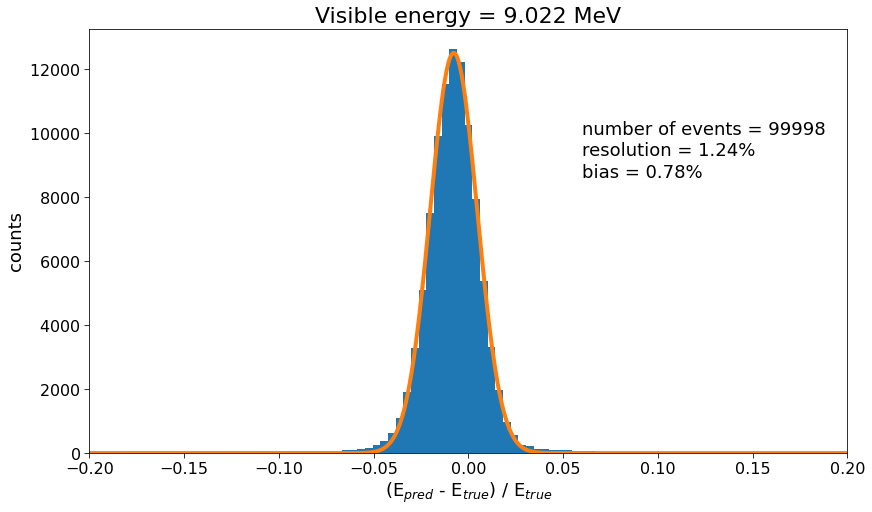

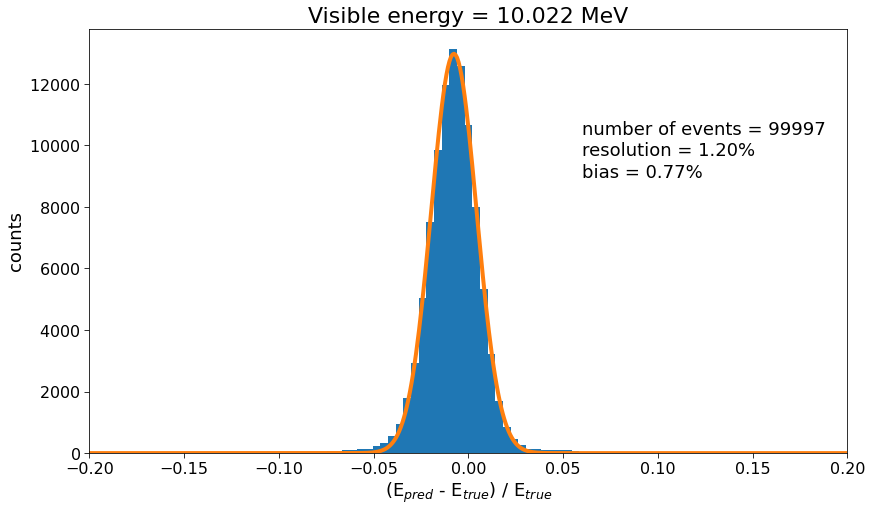

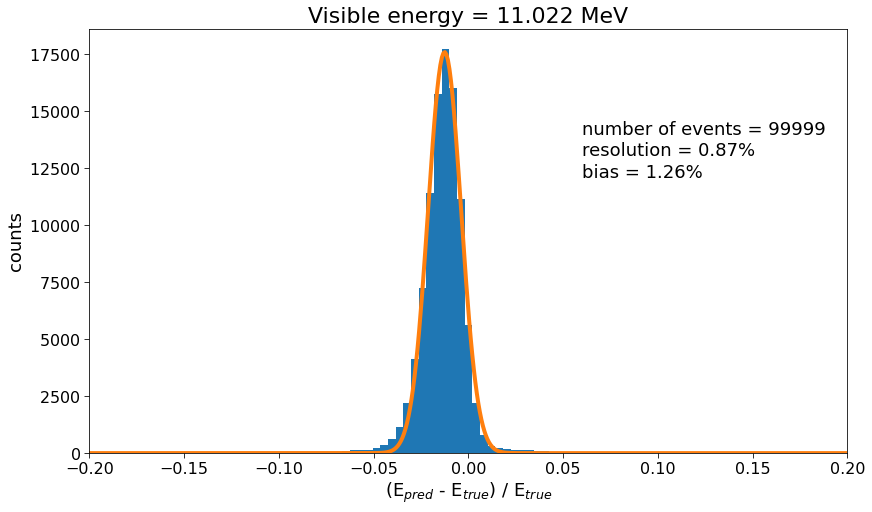

In [35]:
resolution_     = []
err_resolution_ = []
bias_           = []
err_bias_       = []

energy = [
    0, 
    0.1, 
    0.3, 
    0.6, 
    1, 
    2, 
    3, 
    4, 
    5, 
    6, 
    7, 
    8, 
    9, 
    10
]

for i, e in enumerate(energies):
    #if e in ["0", "9", "10"]: continue
    
    bins = np.linspace(-0.2, 0.2, 100)
    
    hist, edges = np.histogram(res[e], bins=bins)
    bincenters = (edges[1:] + edges[:-1]) / 2

    xgrid = np.linspace(edges[0], edges[-1], 500)

    n     = res[e].shape[0]
    mean  = res[e].mean()
    sigma = res[e].std()
    popt, pcov = curve_fit(gaus, bincenters, hist, p0=[n, mean, sigma])

    n_events   = edep_pred[e].shape[0]
    resolution = popt[2]
    bias       = popt[1]

    resolution_.append(resolution)
    err_resolution_.append(np.sqrt(np.diag(pcov))[2])
    bias_.append(bias)
    err_bias_.append(np.sqrt(np.diag(pcov))[2])

    fig = plt.figure(figsize=(12,7), constrained_layout=True)
    ax  = fig.add_subplot(111)

    ax.hist(bincenters, weights=hist, bins=bins)
    ax.plot(xgrid, gaus(xgrid, *popt), lw=4)
    ax.text(0.65, 0.75, f"number of events = {n_events}", fontsize=18,transform=ax.transAxes)
    ax.text(0.65, 0.7, f"resolution = {resolution*100:.2f}%", fontsize=18,transform=ax.transAxes)
    ax.text(0.65, 0.65, f"bias = {abs(bias)*100:.2f}%", fontsize=18,transform=ax.transAxes)

    ax.set_title(f"Visible energy = {energy[i]+1.022:.3f} MeV", fontsize=22)
    ax.set_xlabel("(E$_{pred}$ - E$_{true}$) / E$_{true}$", fontsize=18)
    ax.set_ylabel("counts", fontsize=18)
    ax.set_xlim(xmin=-0.2, xmax=0.2)

    # ax.set_yscale("log")

    ax.tick_params(axis="both", which="major", labelsize=16, length=5)
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.get_offset_text().set_fontsize(16)

    fig.savefig(f"../images/resnet/e_{e}mev_hist.png", dpi=300, facecolor="white")


In [36]:
energy = [
    0, 
    0.1, 
    0.3, 
    0.6, 
    1, 
    2, 
    3, 
    4, 
    5, 
    6, 
    7, 
    8, 
    9, 
    10
]
results = pd.DataFrame(
    {
        "energy":         energy,
        "resolution":     resolution_,
        "err_resolution": err_resolution_,
        "bias":           np.abs(bias_),
        "err_bias":       err_bias_
    }
)
results

,energy,resolution,err_resolution,bias,err_bias
0,0.0,0.033595,0.000130,0.005121,0.000130
1,0.1,0.032303,0.000140,0.006649,0.000140
2,0.3,0.029791,0.000098,0.012124,0.000098
3,0.6,0.026022,0.000080,0.009761,0.000080
4,1.0,0.022860,0.000066,0.009064,0.000066
5,2.0,0.018858,0.000060,0.008529,0.000060
6,3.0,0.016701,0.000057,0.008239,0.000057
7,4.0,0.015372,0.000048,0.008198,0.000048
8,5.0,0.014285,0.000055,0.007937,0.000055
9,6.0,0.013621,0.000054,0.007936,0.000054


In [37]:
mask = (results.energy != 0) & (results.energy != 9) & (results.energy != 10) 

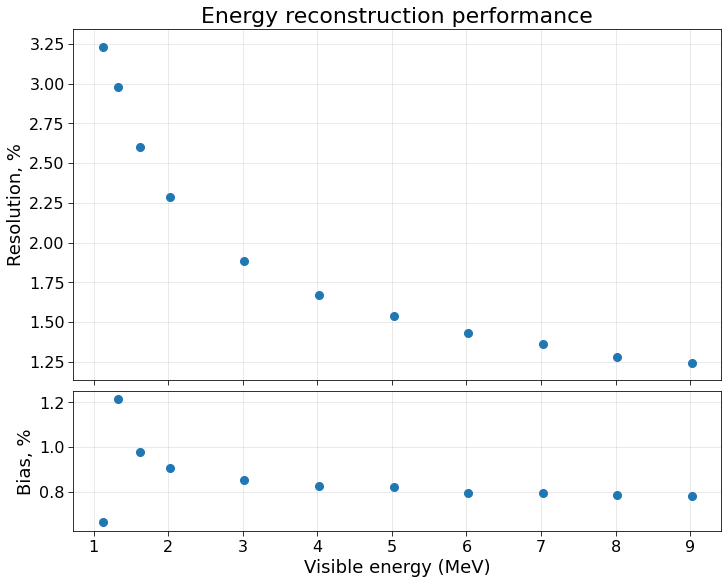

In [39]:
fig = plt.figure(figsize=(10,8), constrained_layout=True)

gs = fig.add_gridspec(2, 1, height_ratios=[5, 2]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(color="k", alpha=0.1)
ax2.grid(color="k", alpha=0.1)

ax1.errorbar(
    results[mask].energy + 1.022, 
    results[mask].resolution * 100, 
    yerr=results[mask].err_resolution * 100,
    marker="o",
    ls="none",
    #color="#000000",
    linewidth=0, 
    elinewidth=1, 
    capsize=2, 
    markersize=8
)

ax2.errorbar(
    results[mask].energy + 1.022, 
    results[mask].bias * 100, 
    yerr=results[mask].err_bias * 100,
    marker="o",
    ls="none",
    #color="#000000",
    linewidth=0, 
    elinewidth=1, 
    capsize=2, 
    markersize=8
)

ax1.set_title(f"Energy reconstruction performance", fontsize=22)
ax1.set_ylabel("Resolution, %", fontsize=18)
ax2.set_xlabel("Visible energy (MeV)", fontsize=18)
ax2.set_ylabel("Bias, %", fontsize=18)
ax1.tick_params(axis="both", which="major", labelsize=16, length=5)
ax2.tick_params(axis="both", which="major", labelsize=16, length=5)
ax1.set_xticklabels([])
fig.savefig("../images/resnet/performance.png", dpi=300, facecolor="white")
plt.show()


In [43]:
np.savez('edep_pred.npz', **edep_pred)

99997